# Preparation

### Import, constants and functions

In [1]:
import numpy as np
from numpy.random import seed
#seed(12345)

import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import Sequence

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from google.colab import drive
from google.colab.patches import cv2_imshow

In [2]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [3]:
def show_results(history):
  # Show training history (this cell is complete, nothing to implement here :-) )
  h = history.history
  epochs = range(len(h['loss']))

  plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
  plt.legend(['Train', 'Validation'])
  plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                            epochs, h['val_accuracy'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])

  print('Train Acc     ', h['accuracy'][-1])
  print('Validation Acc', h['val_accuracy'][-1])

In [4]:
def comparison(test_dataset, decoded_imgs, n):
  for ii in range(n):
      image_num = np.random.randint(0, len(test_dataset))

      plt.subplot(2,n,ii+1), plt.imshow(test_dataset[image_num, ...])
      plt.title("original")

      plt.subplot(2,n,ii+1+n), plt.imshow(decoded_imgs[image_num, ...])
      plt.title("reconstructed")

In [5]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [6]:
# Load data from the folder
#with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data/train_dataset.npy', 'rb') as f:
#    train_dataset = np.load(f)

#with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data/test_dataset.npy', 'rb') as f:
#    test_dataset = np.load(f)
with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data_X/train_dataset_small.npy', 'rb') as f:
    train_dataset = np.load(f)

with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data_X/test_dataset_small.npy', 'rb') as f:
    test_dataset = np.load(f)

In [7]:
hight = train_dataset.shape[1]
width = train_dataset.shape[2]

### Data inspaction

In [8]:
print('Train set:   ', len(train_dataset), 'samples')
print('Test set:    ', len(test_dataset), 'samples')
print('Sample dims: ', train_dataset.shape)

Train set:    432 samples
Test set:     144 samples
Sample dims:  (432, 108, 192, 3)


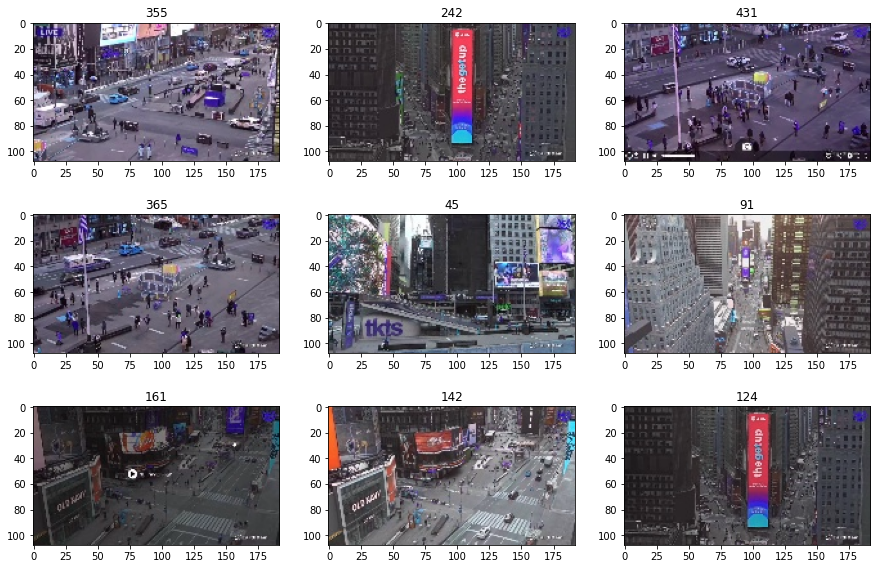

In [9]:
# Show random samples
for ii in range(9):
    image_num = np.random.randint(0, len(train_dataset))
    plt.subplot(3,3,ii+1), plt.imshow(train_dataset[image_num, ...])
    plt.title(str(image_num))

#Building model

In [10]:
# Normalization
train_dataset = train_dataset.astype('float32')/255
test_dataset = test_dataset.astype('float32')/255

## Create model

In [11]:
latent_dim = 5000 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
        #layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
        #layers.MaxPooling2D(pool_size=(2, 2)),
        #layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
        #layers.MaxPooling2D(pool_size=(2, 2)),
        #layers.Conv2D(254, kernel_size=(3, 3), activation="relu", padding='same'),
        #layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(latent_dim, activation='relu')
    ], name='encoder')
    self.decoder = tf.keras.Sequential([        
        layers.Dense(width*hight*3, activation='sigmoid'),
        layers.Reshape((hight, width, 3))
        #layers.Conv2DTranspose(64, kernel_size=(3, 3), activation="relu", padding='same'),
        #layers.BatchNormalization(),
        #layers.LeakyReLU(alpha=0.2),
        #layers.Conv2DTranspose(128, kernel_size=(3, 3), activation="relu", padding='same'),
        #layers.LeakyReLU(alpha=0.2),
        #layers.Conv2DTranspose(256, kernel_size=(3, 3), activation="relu", padding='same'),        
        #layers.BatchNormalization(),
        #layers.Conv2DTranspose(3, kernel_size=(1, 1), activation="relu", padding='same')
    ], name='decoder')

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [12]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=["accuracy"])

In [13]:
epochs = 30
batch_size = 32
history = autoencoder.fit(DataGenerator(train_dataset, train_dataset, batch_size),
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(DataGenerator(test_dataset, test_dataset, batch_size)))

Epoch 1/30
14/14 [==============================] - 40s 3s/step - loss: 0.0630 - accuracy: 0.3971 - val_loss: 0.0472 - val_accuracy: 0.4654
Epoch 2/30
14/14 [==============================] - 37s 3s/step - loss: 0.0522 - accuracy: 0.4313 - val_loss: 0.0458 - val_accuracy: 0.5027
Epoch 3/30
14/14 [==============================] - 37s 3s/step - loss: 0.0431 - accuracy: 0.5170 - val_loss: 0.0483 - val_accuracy: 0.4380
Epoch 4/30
14/14 [==============================] - 37s 3s/step - loss: 0.0405 - accuracy: 0.4443 - val_loss: 0.0368 - val_accuracy: 0.5291
Epoch 5/30
14/14 [==============================] - 37s 3s/step - loss: 0.0388 - accuracy: 0.5370 - val_loss: 0.0352 - val_accuracy: 0.5774
Epoch 6/30
14/14 [==============================] - 44s 3s/step - loss: 0.0373 - accuracy: 0.5784 - val_loss: 0.0423 - val_accuracy: 0.5851
Epoch 7/30
14/14 [==============================] - 37s 3s/step - loss: 0.0409 - accuracy: 0.5031 - val_loss: 0.0348 - val_accuracy: 0.5839
Epoch 8/30
14/14 [==

Train Acc      0.6682676076889038
Validation Acc 0.6713759899139404


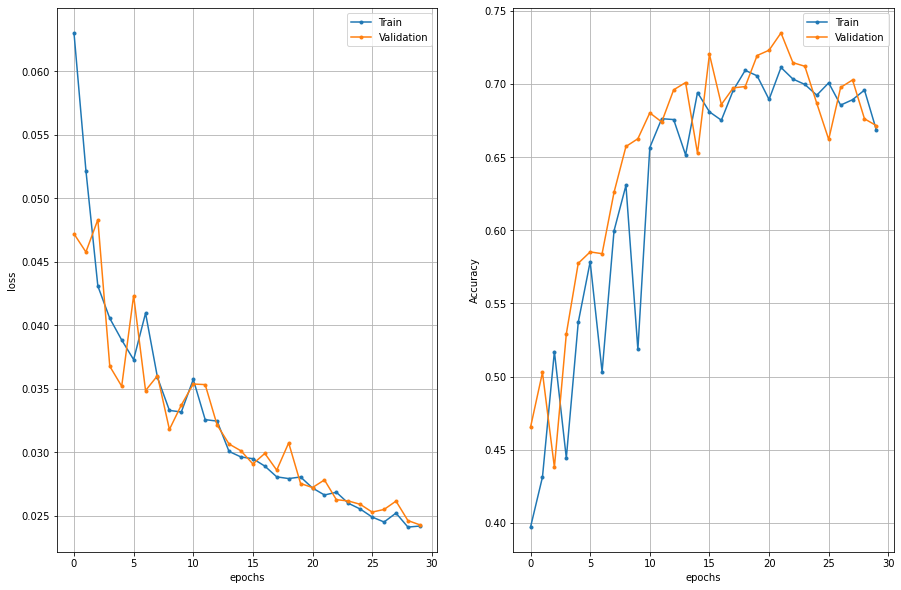

In [14]:
show_results(history)

In [15]:
encoded_imgs = autoencoder.encoder(test_dataset).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

#with open('drive/MyDrive/Colab Notebooks/encoded_imgs.npy', 'wb') as f:
#    np.save(f, encoded_imgs)

In [16]:
print('Sample encoded: ', encoded_imgs.shape)
print('Sample decoded: ', decoded_imgs.shape)
print('comression: ', decoded_imgs.shape[1]*decoded_imgs.shape[2]*decoded_imgs.shape[3]/encoded_imgs.shape[1])

Sample encoded:  (144, 5000)
Sample decoded:  (144, 108, 192, 3)
comression:  12.4416


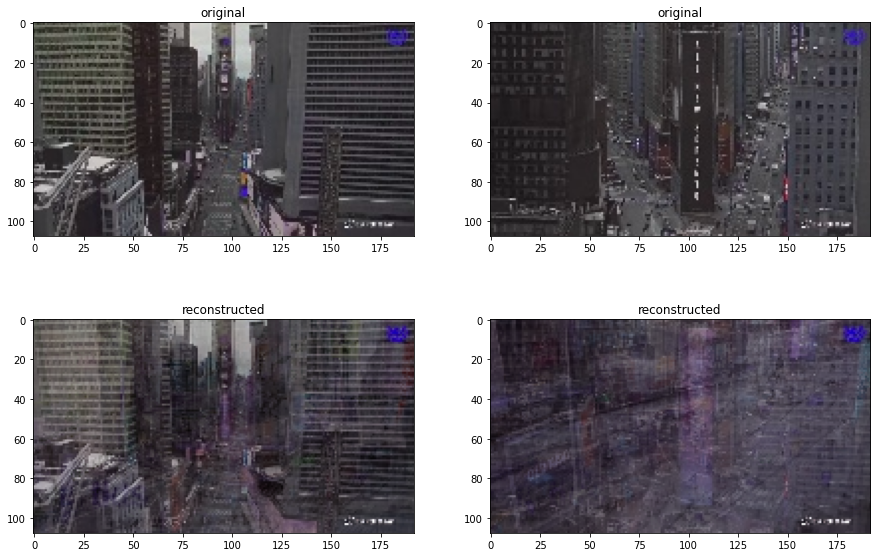

In [17]:
# Show random comparison
comparison(test_dataset, decoded_imgs, 2)

In [18]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 5000)              311045000 
                                                                 
 decoder (Sequential)        (None, 108, 192, 3)       311102208 
                                                                 
Total params: 622,147,208
Trainable params: 622,147,208
Non-trainable params: 0
_________________________________________________________________


In [19]:
autoencoder.encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, None)              0         
                                                                 
 dense (Dense)               (None, 5000)              311045000 
                                                                 
Total params: 311,045,000
Trainable params: 311,045,000
Non-trainable params: 0
_________________________________________________________________


In [20]:
autoencoder.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 62208)             311102208 
                                                                 
 reshape (Reshape)           (None, 108, 192, 3)       0         
                                                                 
Total params: 311,102,208
Trainable params: 311,102,208
Non-trainable params: 0
_________________________________________________________________
